## Support Vector Regression (SVR)
(LinearSVR + MultiOutputRegressor)
 - Balanced sample by unique (Vbus..Ls11) combinations
 - 70/15/15 split
 - Standardize X and y
 - LinearSVR per target (MultiOutputRegressor)
 - Metrics (R2 / RMSE / MAE) for train/val/test
 - Plots: R2 bars (Val vs Test), Test scatter, residual histograms,
         residual vs predicted, and mean |coef| feature importance

[INFO] Using 86335 rows after balanced FAST sampling
[INFO] Train time: 4.73s

=== Train Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9145 1.1782e-09 8.9444e-10
voltage_rise_time_pulse2 0.6353 2.6559e-09 1.3920e-09
voltage_fall_time_pulse1 0.9826 8.9905e-10 6.8399e-10
voltage_fall_time_pulse2 0.9826 8.9824e-10 6.8299e-10
current_rise_time_pulse1 0.8862 1.5966e-08 1.0658e-08
current_rise_time_pulse2 0.7855 1.2316e-08 9.5811e-09
current_fall_time_pulse1 0.9634 2.4498e-09 1.8659e-09
current_fall_time_pulse2 0.9630 2.4594e-09 1.8777e-09
       overshoot_pulse_1 0.8401 5.3701e+00 4.0004e+00
       overshoot_pulse_2 0.8311 1.1003e+01 8.4593e+00
      undershoot_pulse_1 0.8789 4.7300e+00 3.2581e+00
      undershoot_pulse_2 0.8799 4.7063e+00 3.2593e+00
   ringing_frequency_MHz 0.9949 2.3096e+00 1.6187e+00
R2_avg          0.8875
RMSE_avg    3.9200e+00
MAE_avg     1.5843e+00
dtype: object

=== Validation Set ===
                  Target     R2       RM

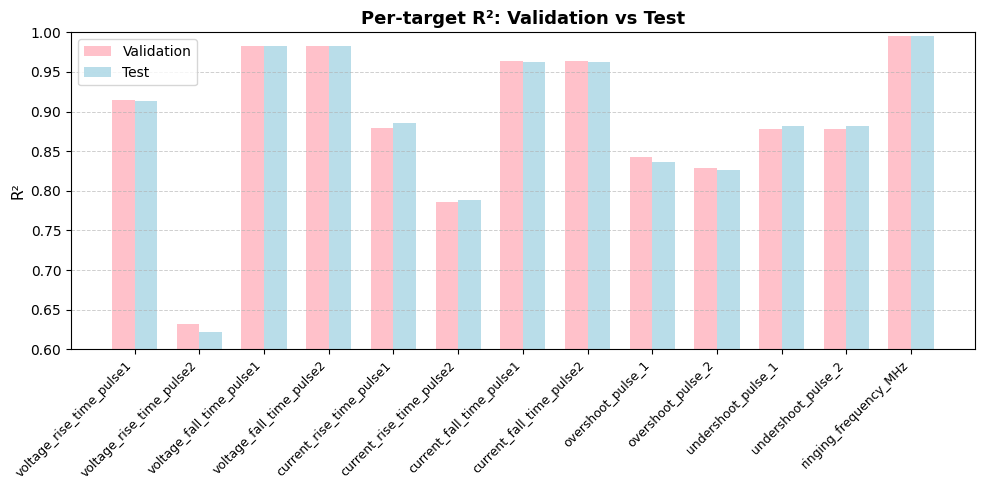

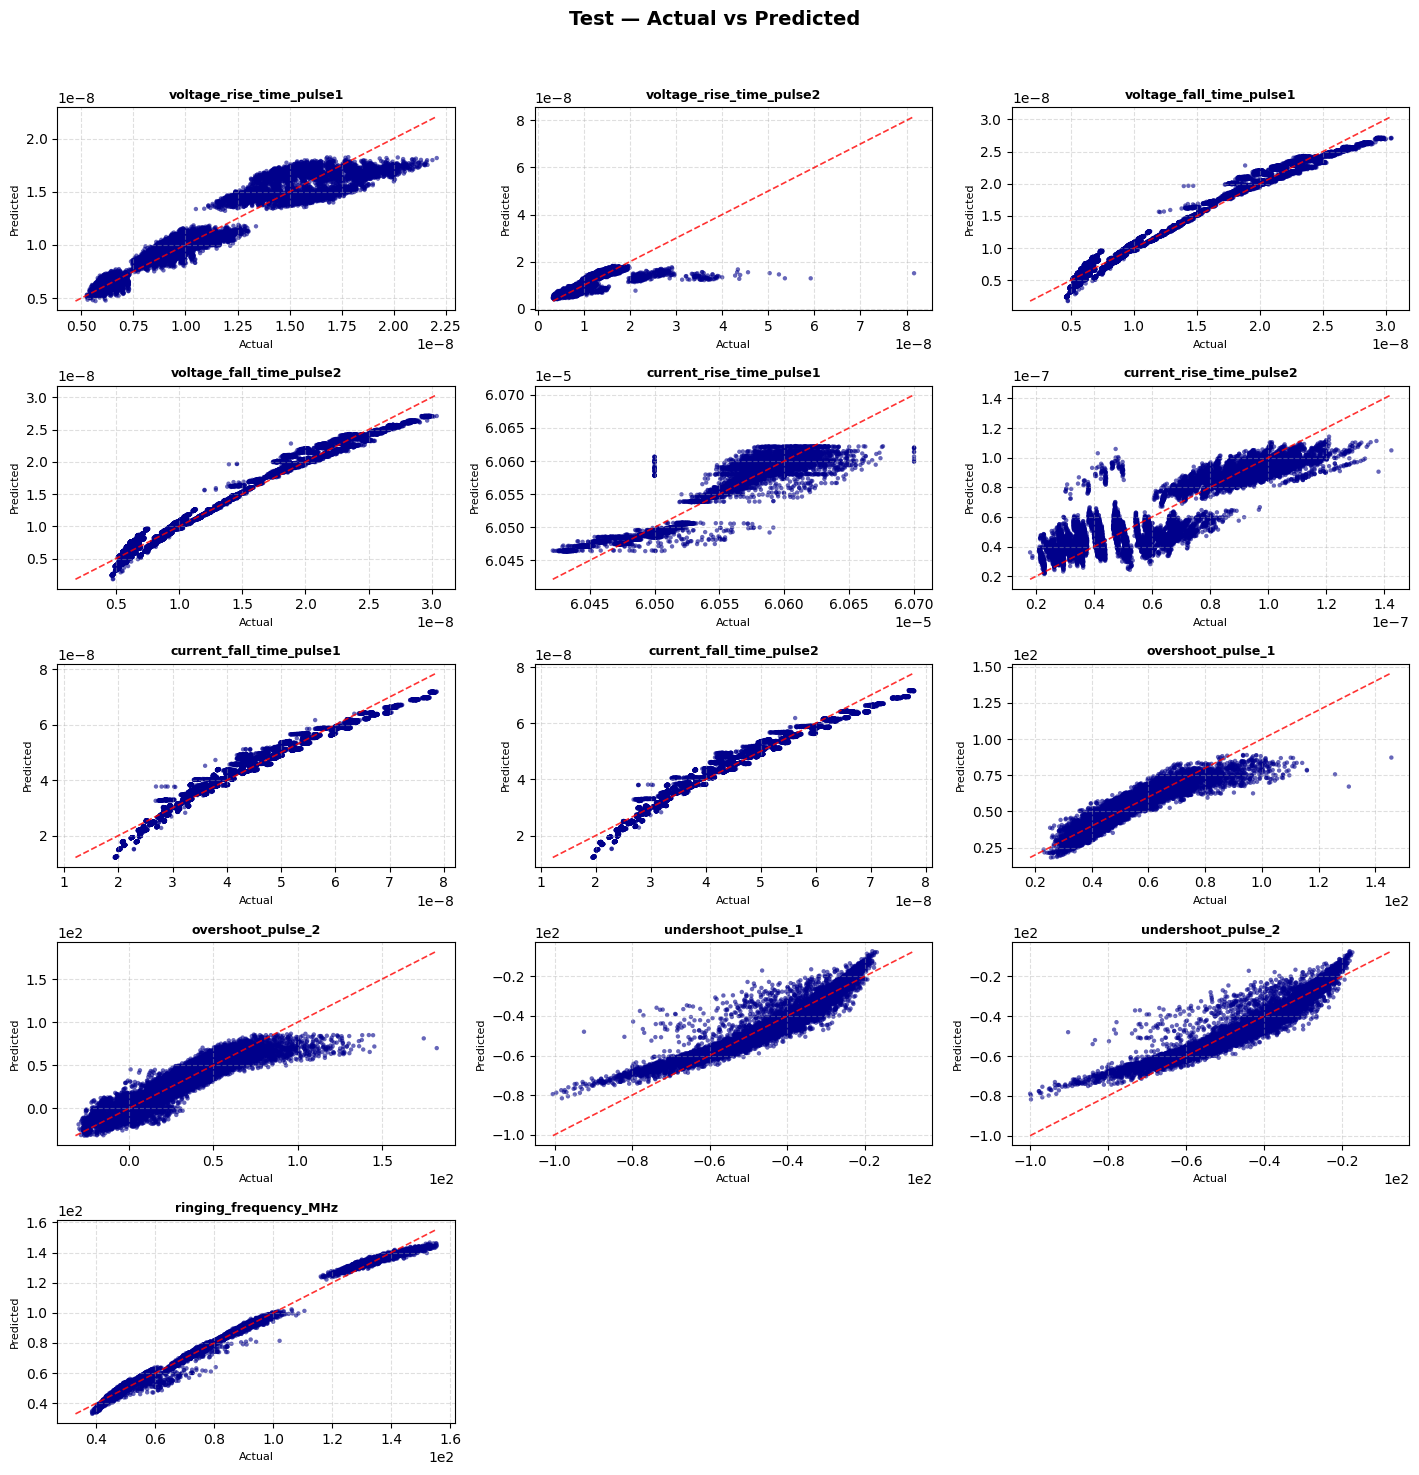

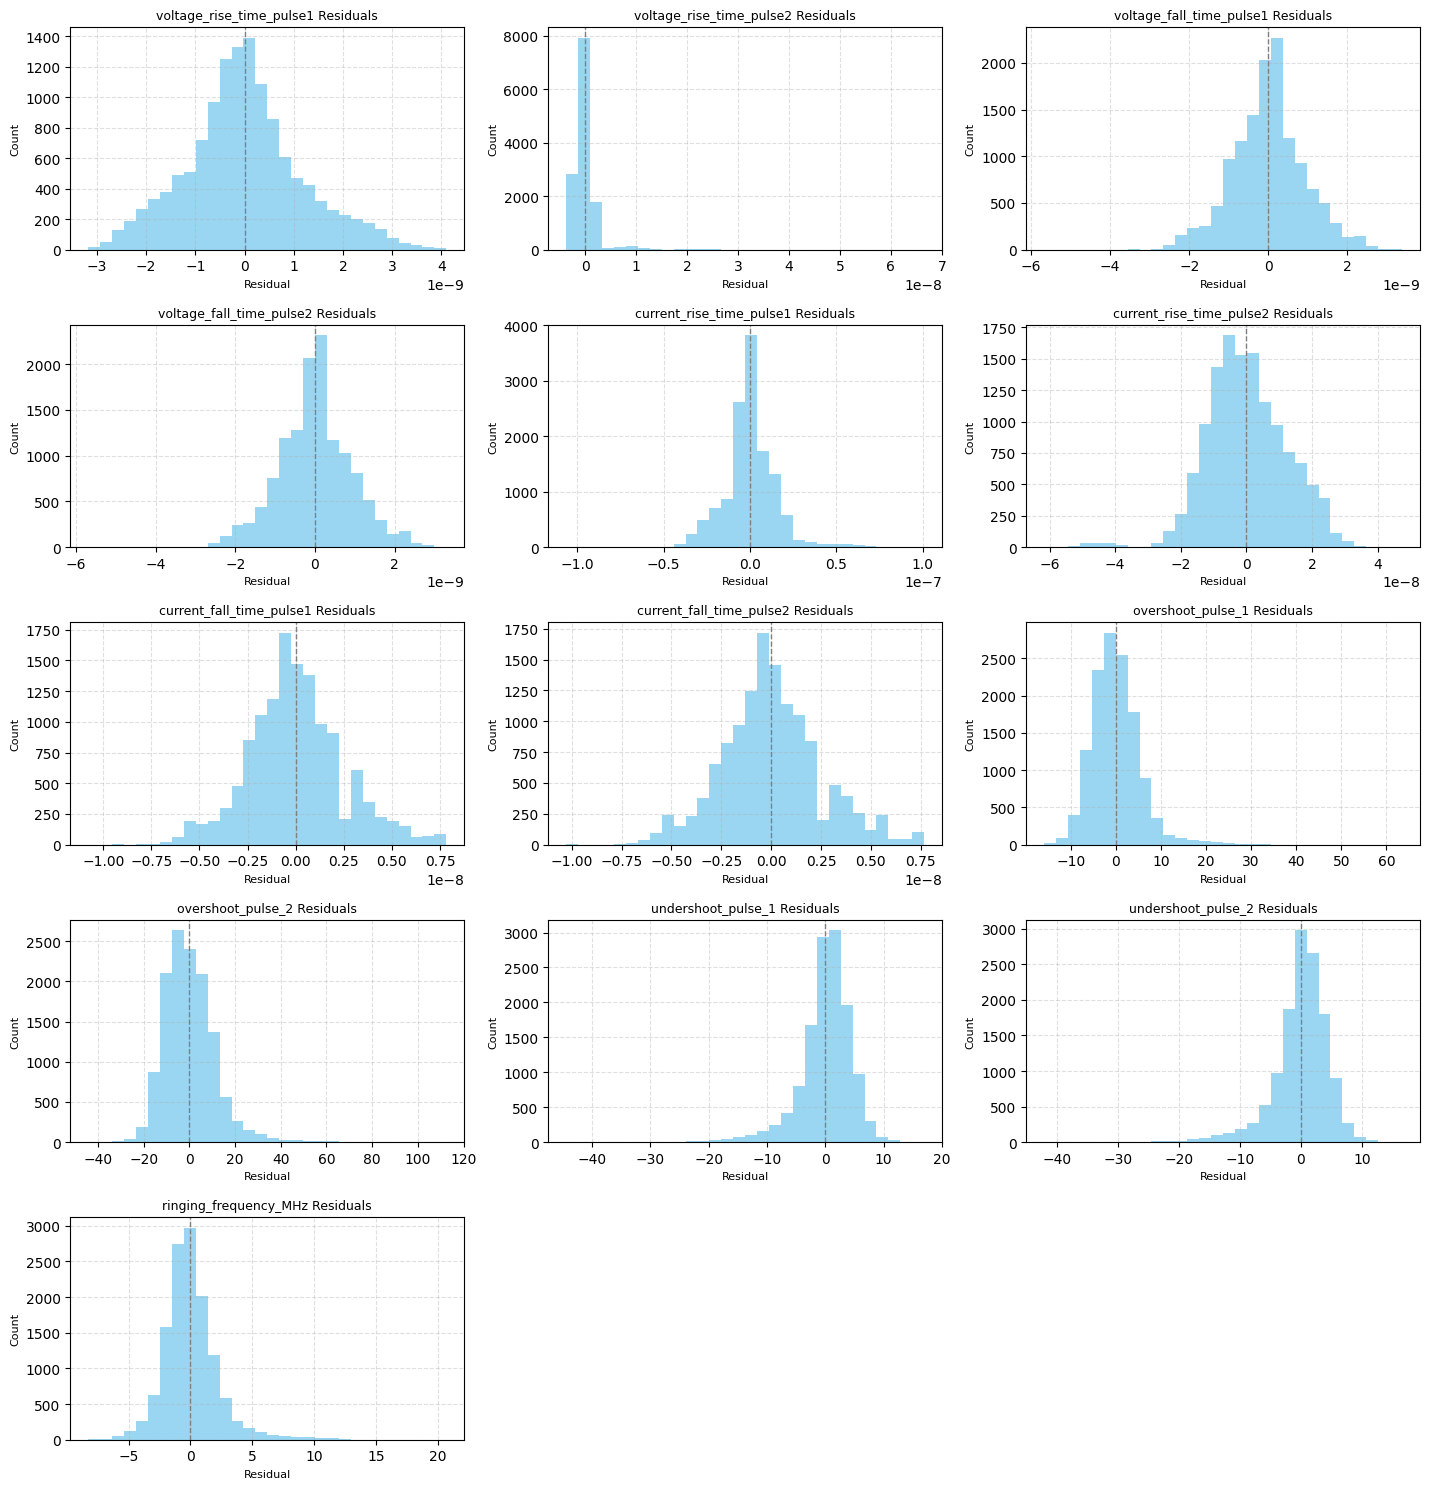

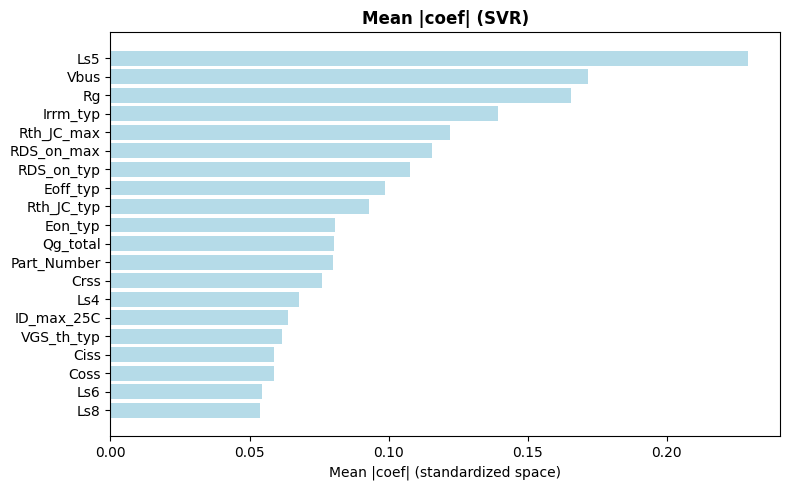

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ===================== Config =====================
TRAIN_FILE   = r"C:\Users\pc\Desktop\THESIS_DISTINCTION_THRISHA_RAJKUMAR\merged_train_5_MOSFETs.csv"
RANDOM_STATE = 42

FAST_FRAC    = 0.25     # sample this fraction *within each* (Vbus..Ls11) combinations - 
# Balanced dataset

# Plotting
GRID_COLS    = 3        # columns in grid-style plots
TOP_FEATURES = 20       # top-N features in coefficient-based importance

# === Targets (13 EMI outputs) ===
TARGETS = [
    'voltage_rise_time_pulse1','voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1','voltage_fall_time_pulse2',
    'current_rise_time_pulse1','current_rise_time_pulse2',
    'current_fall_time_pulse1','current_fall_time_pulse2',
    'overshoot_pulse_1','overshoot_pulse_2',
    'undershoot_pulse_1','undershoot_pulse_2',
    'ringing_frequency_MHz'
]

# === Columns defining each simulation configuration ===
# (Used to sample *evenly* across unique setups for FAST_FRAC)
COMBO_COLS = ["Vbus","Rg","Ls4","Ls5","Ls6","Ls7","Ls8","Ls9","Ls10","Ls11"]


# 1) Data helpers

def encode_or_drop_objects(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encode 'Part_Number' (MOSFET identity) to numeric and drop any other object columns.
    NOTE: LabelEncoder imposes an arbitrary order on categories; if you want
    strictly linear models to avoid ordinal artifacts, consider OneHotEncoder
    instead. LinearSVR requires numeric inputs only.
    """
    if "Part_Number" in df.columns:
        le = LabelEncoder()
        df["Part_Number"] = le.fit_transform(df["Part_Number"].astype(str))
    # Drop any remaining non-numeric columns to keep SVR stable
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    if obj_cols:
        df = df.drop(columns=obj_cols)
    return df

def balanced_sample_by_combo(df: pd.DataFrame,
                             combo_cols,
                             frac: float = FAST_FRAC,
                             seed: int = RANDOM_STATE) -> pd.DataFrame:
    """
    Take the same fraction of rows from inside each unique (Vbus..Ls11) combo.
    This preserves the distribution of simulation setups while shrinking the dataset.
    """
    if frac >= 1.0:
        return df.reset_index(drop=True)
    rng = np.random.default_rng(seed)
    parts = []
    # Group by combo; sample a fixed fraction from each group
    for _, g in df.groupby(combo_cols, dropna=False, sort=False):
        n = max(1, int(round(frac * len(g))))
        n = min(n, len(g))
        idx = rng.choice(g.index.to_numpy(), size=n, replace=False)
        parts.append(df.loc[idx])
    return pd.concat(parts, axis=0).sort_index().reset_index(drop=True)

def split_70_15_15(X, y, seed=RANDOM_STATE):
    """
    Return (X_train, X_val, X_test, y_train, y_val, y_test).
    Uses a 70/15/15 split by first doing 70/30, then splitting the 30% in half.
    """
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.30, random_state=seed, shuffle=True)
    X_va, X_te,  y_va, y_te  = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=seed, shuffle=True)
    return X_tr, X_va, X_te, y_tr, y_va, y_te

# ------------------------------------------------------------
# 2) Model + metrics
# ------------------------------------------------------------
def build_linear_svr(seed=RANDOM_STATE) -> LinearSVR:
    """
    Configure a LinearSVR:
    - loss='squared_epsilon_insensitive' is the default squared epsilon loss.
    - C controls regularization strength (higher C = less regularization).
    - epsilon defines the margin of no penalty (kept 0.0 for simplicity).
    - max_iter raised for convergence.
    """
    return LinearSVR(
        C=1.0,
        epsilon=0.0,
        loss="squared_epsilon_insensitive",
        max_iter=5000,
        random_state=seed
    )

def train_multioutput_svr(X_train_s, y_train_s):
    """
    Fit one LinearSVR per target using MultiOutputRegressor.
    Note: Each target is independent; there is no cross-target coupling here.
    """
    model = MultiOutputRegressor(build_linear_svr(RANDOM_STATE), n_jobs=-1)
    t0 = time.time()
    model.fit(X_train_s, y_train_s)
    train_time = time.time() - t0
    return model, train_time

def predict_with_timer(model, X):
    """
    Predict and compute latency in ms/sample for reporting.
    """
    t0 = time.time()
    y_pred = model.predict(X)
    ms_per_sample = (time.time() - t0) / max(1, len(X)) * 1000.0
    return y_pred, ms_per_sample

def compute_metrics(y_true, y_pred):
    """
    Build a per-target metrics table and overall averages.
    Metrics: R2, RMSE, MAE (RMSE/MAE are in the natural physical units).
    """
    rows = []
    for i, t in enumerate(TARGETS):
        yt, yp = y_true[:, i], y_pred[:, i]
        rows.append([
            t,
            r2_score(yt, yp),
            np.sqrt(mean_squared_error(yt, yp)),
            mean_absolute_error(yt, yp),
        ])
    per_target = pd.DataFrame(rows, columns=["Target", "R2", "RMSE", "MAE"])
    overall = {
        "R2_avg":   r2_score(y_true, y_pred, multioutput="uniform_average"),
        "RMSE_avg": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE_avg":  mean_absolute_error(y_true, y_pred),
    }
    return per_target, overall

def print_metrics(title: str, per_target: pd.DataFrame, overall: dict):
    """
    Nicely formatted console output for per-target and overall metrics.
    """
    pretty = per_target.copy()
    pretty["R2"]   = pretty["R2"].map(lambda x: f"{x:.4f}")
    pretty["RMSE"] = pretty["RMSE"].map(lambda x: f"{x:.4e}")
    pretty["MAE"]  = pretty["MAE"].map(lambda x: f"{x:.4e}")
    overall_pretty = {k: (f"{v:.4f}" if "R2" in k else f"{v:.4e}") for k, v in overall.items()}

    print(f"\n=== {title} ===")
    print(pretty.to_string(index=False))
    print(pd.Series(overall_pretty))

# ------------------------------------------------------------
# 3) Plots 
# ------------------------------------------------------------
def plot_r2_bars(val_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Grouped bars for Validation vs Test R².
    Helps visualize per-target generalization.
    """
    targets = val_df["Target"].tolist()
    x = np.arange(len(targets))
    width = 0.35

    fig, ax = plt.subplots(figsize=(max(10, 0.6*len(targets)), 5))
    ax.bar(x - width/2, val_df["R2"].values,  width, label="Validation",
           color="#ffb6c1", alpha=0.85)
    ax.bar(x + width/2, test_df["R2"].values, width, label="Test",
           color="#add8e6", alpha=0.85)

    ax.set_xticks(x)
    ax.set_xticklabels(targets, rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("R²", fontsize=11)
    ax.set_title("Per-target R²: Validation vs Test", fontsize=13, weight="bold")
    ax.set_ylim(0.6, 1.0)
    ax.grid(axis='y', linestyle='--', alpha=0.6, linewidth=0.7)
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_test_scatter(y_true, y_pred, target_names, n_cols=GRID_COLS):
    """
    Actual vs Predicted (Test) per target.
    Blue points + red dashed y=x line.
    Curvature or spread away from the diagonal hints at model bias or missing non-linearities.
    """
    n_targets = len(target_names)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 3*n_rows))
    axes = axes.flatten()

    for i, t in enumerate(target_names):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], s=10, alpha=0.6,
                   color="darkblue", edgecolors="none")
        mn = min(y_true[:, i].min(), y_pred[:, i].min())
        mx = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([mn, mx], [mn, mx], '--', lw=1.2, color="red", alpha=0.8)
        ax.set_title(t, fontsize=9, weight="bold")
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
        ax.set_xlabel("Actual", fontsize=8)
        ax.set_ylabel("Predicted", fontsize=8)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.suptitle("Test — Actual vs Predicted", fontsize=14, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_residual_histograms(y_true, y_pred, target_names, n_cols=GRID_COLS, bins=30):
    """
    Residual histograms (Actual - Predicted) per target.
    Symmetry around zero suggests unbiased errors.
    Heavy tails or skew indicate potential outliers or model misspecification.
    """
    res = y_true - y_pred
    n_targets = len(target_names)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 3*n_rows))
    axes = axes.flatten()

    for i, t in enumerate(target_names):
        ax = axes[i]
        ax.hist(res[:, i], bins=bins, alpha=0.85, color="#89cff0")
        ax.axvline(0.0, linestyle='--', linewidth=1, color="gray")
        ax.set_title(f"{t} Residuals", fontsize=9)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.set_xlabel("Residual", fontsize=8)
        ax.set_ylabel("Count", fontsize=8)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

def plot_coef_importance_mean(model, feature_names, top_n=TOP_FEATURES, title="Mean |coef| (SVR)"):
    """
    LinearSVR is linear in standardized space: coef_ indicates direction/magnitude.
    Here we:
      - take absolute coefficients per target,
      - average across targets,
      - show the top-N features.
    """
    coefs = []
    for est in model.estimators_:
        coefs.append(np.abs(est.coef_.ravel()))  # shape: (n_features,)
    coefs = np.array(coefs)                      # (n_targets, n_features)
    mean_imp = coefs.mean(axis=0)
    order = np.argsort(mean_imp)[::-1]
    top = min(top_n, len(feature_names))
    labels = np.array(feature_names)[order][:top][::-1]
    values = mean_imp[order][:top][::-1]

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.barh(labels, values, color="#add8e6", alpha=0.9)
    ax.set_title(title, fontsize=12, weight="bold")
    ax.set_xlabel("Mean |coef| (standardized space)")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 4) Main pipeline
# ------------------------------------------------------------
def main():
    # A) Load & basic clean
    df = pd.read_csv(TRAIN_FILE).dropna().reset_index(drop=True)
    df = encode_or_drop_objects(df)       # encode 'Part_Number' and drop stray objects
    df = df.dropna(subset=TARGETS)        # ensure all targets are present

    # B) Balanced sample within each (Vbus..Ls11) combo to keep coverage but reduce size
    df = balanced_sample_by_combo(df, COMBO_COLS, frac=FAST_FRAC, seed=RANDOM_STATE)
    print(f"[INFO] Using {len(df)} rows after balanced FAST sampling")

    # C) Features and targets
    feature_cols = [c for c in df.columns if c not in TARGETS]
    # Cast features to float32 (SVR uses dense linear algebra; float32 saves memory/time)
    for c in feature_cols:
        df[c] = df[c].astype(np.float32)

    X_all = df[feature_cols].to_numpy(dtype=np.float32)
    y_all = df[TARGETS].to_numpy(dtype=np.float32)

    # D) Split (70/15/15)
    X_tr, X_va, X_te, y_tr, y_va, y_te = split_70_15_15(X_all, y_all, seed=RANDOM_STATE)

    # E) Scale X and y (important for SVR)
    #    - SVR is sensitive to feature scales; standardizing X is crucial.
    #    - Standardizing y stabilizes targets with different magnitudes so each SVR
    #      sees a similar scale; we invert the transform for reporting/plots.
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_tr_s = x_scaler.fit_transform(X_tr)
    X_va_s = x_scaler.transform(X_va)
    X_te_s = x_scaler.transform(X_te)

    y_tr_s = y_scaler.fit_transform(y_tr)
    y_va_s = y_scaler.transform(y_va)
    y_te_s = y_scaler.transform(y_te)

    # F) Train (one LinearSVR per target)
    model, train_time = train_multioutput_svr(X_tr_s, y_tr_s)
    print(f"[INFO] Train time: {train_time:.2f}s")

    # G) Predict (then inverse-transform y back to physical units)
    y_tr_pred_s, tr_ms = predict_with_timer(model, X_tr_s)
    y_va_pred_s, va_ms = predict_with_timer(model, X_va_s)
    y_te_pred_s, te_ms = predict_with_timer(model, X_te_s)

    y_tr_pred = y_scaler.inverse_transform(y_tr_pred_s)
    y_va_pred = y_scaler.inverse_transform(y_va_pred_s)
    y_te_pred = y_scaler.inverse_transform(y_te_pred_s)

    # H) Metrics
    tr_tbl, tr_over = compute_metrics(y_tr, y_tr_pred)
    va_tbl, va_over = compute_metrics(y_va, y_va_pred)
    te_tbl, te_over = compute_metrics(y_te, y_te_pred)

    print_metrics("Train Set", tr_tbl, tr_over)
    print_metrics("Validation Set", va_tbl, va_over)
    print(f"Predict Time (ms/sample): Train {tr_ms:.3f} | Val {va_ms:.3f}")
    print_metrics("Test Set", te_tbl, te_over)
    print(f"Predict Time (ms/sample): Test {te_ms:.3f}")

    # I) Plots
    plot_r2_bars(va_tbl, te_tbl)                               # R² bars (Val vs Test)
    plot_test_scatter(y_te, y_te_pred, TARGETS, GRID_COLS)     # Test scatter (Actual vs Pred)
    plot_residual_histograms(y_te, y_te_pred, TARGETS)         # Residual histograms
    plot_coef_importance_mean(model, feature_cols, TOP_FEATURES)  # Mean |coef| from LinearSVR

if __name__ == "__main__":
    main()
